
## Before you start
Before starting this notebook make sure that you installed the necessary packages. In this notebook we use 'rasterio' as the package for handling raster data. You can find the complete manual of rasterio at [https://rasterio.readthedocs.io/](https://rasterio.readthedocs.io/en/latest/)

## Load the necessary packages

We start by importing the necessary packages

In [31]:
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

## Rasterio
Once we have raster data on our computer, we can open them using `rasterio`. Rasterio reads and writes geospatial raster datasets. It employs GDAL under the hood for file I/O and raster formatting. Its functions typically accept and return Numpy ndarrays. Rasterio is designed to make working with geospatial raster data more productive and more fun.

Consider a GeoTIFF file named `Data/case_study/geonode__fl1010irmt.tif` you will use in the case study. We first need to open it with rasterio

In [2]:
filename = 'Data/case_study/geonode__fl1010irmt.tif'
dataset = rasterio.open(filename)

Rasterio’s open() function takes a path string or path-like object and returns an opened dataset object. The path may point to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [3]:
dataset.name

'Data/case_study/geonode__fl1010irmt.tif'

Properties of the raster data stored in the example GeoTIFF can be accessed through attributes of the opened dataset object. Dataset objects have bands/layers and this example has a band count of 1 this dataset has only one raster layer.

In [4]:
dataset.count

1

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns.

In [5]:
print(dataset.width)
print(dataset.height)

4320
2088


### Raster georeferencing
A GIS raster dataset is different from an ordinary image; its elements (or “pixels”) are mapped to regions on the earth’s surface. Every pixels of a dataset is contained within a spatial bounding box. In this case it are the coordinates in the output `crs` we defined when exporting.



In [6]:
dataset.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999858, top=83.99999999999932)

In [7]:
dataset.crs

CRS.from_epsg(4326)

The value of DatasetReader.bounds attribute is derived from a more fundamental attribute: the dataset’s geospatial transform.

In [8]:
dataset.transform

Affine(0.08333333333333301, 0.0, -180.0,
       0.0, -0.08333333333333301, 83.99999999999932)

### Reading raster data
Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1 (and not 0 as in most python arrays)

In [9]:
band1 = dataset.read(1)

The read() method returns a Numpy N-D array.

In [10]:
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Instead of reading single bands, all bands of the input dataset can also be read into a 3-dimensonal ndarray. Note that the interpretation of the 3 axes is `(bands, rows, columns)`. 

In [11]:
bands = dataset.read()
bands.shape

(1, 2088, 4320)

The interpretation of a 3-dimension array read from rasterio is `(bands, rows, columns)` while image processing software like scikit-image, pillow and matplotlib are generally ordered as `(rows, columns, bands)` where number of rows defines the dataset’s height, the columns are the dataset’s width.

Numpy provides a way to efficiently swap the axis order and you can use the following reshape functions to convert between raster and image axis order:



In [12]:
from rasterio.plot import reshape_as_raster, reshape_as_image
# Convert to image
image = reshape_as_image(bands)
print(image.shape)
# Convert back to raster
raster = reshape_as_raster(image)
print(raster.shape)

(2088, 4320, 1)
(1, 2088, 4320)


Irrespective to the ordering, values from the array can be addressed by their `band, row, column` index. Notice that now indexing starts again at 0 as in classic python arrays

In [13]:
bands[0, 150, 100]

0

## Analyzing & plotting the data
Once the data are downloaded and opened, we can start analyzing like classical numpy arrays



In [14]:
plus1 = bands[0,:,:]+1
plus1

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

We can off course also plot the data in a map using the mapping tools your learned last week

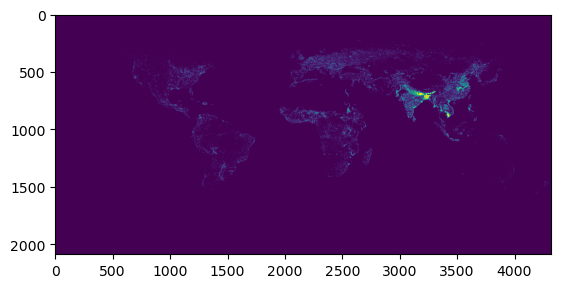

In [15]:
plt.figure()
plt.imshow(raster[0,:,:])

To understand the data distribution, you can plot a histogram of the band values.

Text(0, 0.5, 'Probability density by counts')

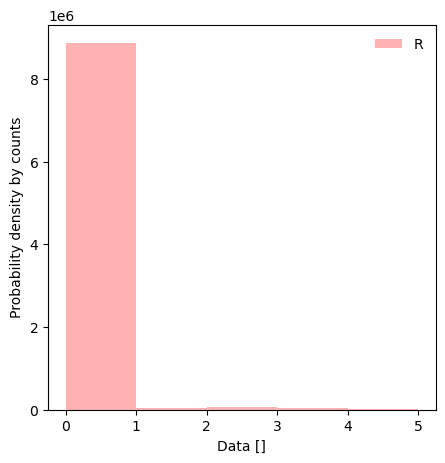

In [16]:
# Plot
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(raster[0,:,:].flatten(),bins=np.arange(0.0, 6, 1),color='red',alpha=0.3,label='R')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('Data []')
ax.set_ylabel('Probability density by counts')

Once you have loaded your data sets you can apply the standard numpy functions to the raster data sets

In [17]:
np.mean(raster)

0.036945686107563505

In [18]:
np.max(raster)

5

In [19]:
np.min(raster)

0

And potentially apply these functions along specific axes:

In [20]:
np.mean(raster,axis=2)

array([[0., 0., 0., ..., 0., 0., 0.]])

### Masked rasters
See also [rasterio manuals on masks](https://rasterio.readthedocs.io/en/latest/topics/masks.html) [and masking](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)
Nodata masks allow you to identify regions of valid data values and/or mask data from your analyses. In using Rasterio, you’ll encounter two different kinds of masks.

One is the the valid data mask from GDAL, an unsigned byte array with the same number of rows and columns as the dataset in which non-zero elements (typically 255) indicate that the corresponding data elements are valid. Other elements are invalid, or nodata elements.

The other kind of mask is a numpy.ma.MaskedArray which has the inverse sense: True values in a masked array’s mask indicate that the corresponding data elements are invalid. With care, you can safely navigate convert between the two mask types.

Consider Rasterio’s RGB.byte.tif test dataset. It has 718 rows and 791 columns of pixels. Each pixel has 3 8-bit (uint8) channels or bands. It has a trapezoid of image data within a rectangular background of 0,0,0 value pixels.

![](Data/images/RGB.byte.jpg)

Metadata in the dataset declares that values of 0 will be interpreted as invalid data or nodata pixels. In, e.g., merging the image with adjacent scenes, we’d like to ignore the nodata pixels and have only valid image data in our final mosaic.

Alternatively you can also use vector data to mask out data that you are not interested in. When using rasterio, it is simple to open vector file, read geometries, and mask out regions of a raster that are outside the polygons defined in the shapefile:


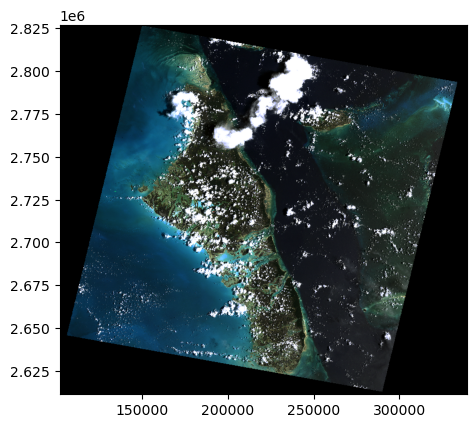

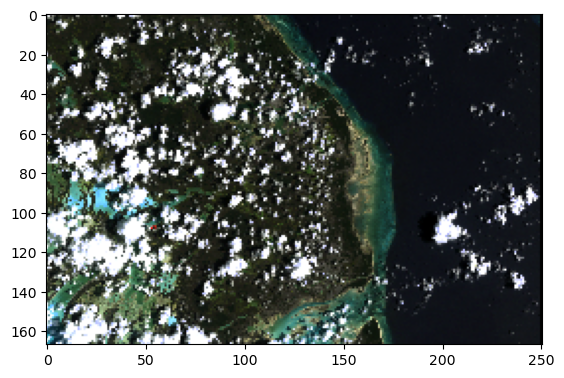

<AxesSubplot:>

In [33]:
shapes = gpd.read_file('Data/raster/box.shp')
raster_src= rasterio.open("Data/raster/RGB.byte.tiff")

rasterio.plot.show(raster_src)

out_image, out_transform = rasterio.mask.mask(raster_src, shapes['geometry'], crop=True)
out_meta = raster_src.meta

rasterio.plot.show(out_image)

Applying the features in the shapefile as a mask on the raster sets all pixels outside of the features to be zero. Since crop=True in this example, the extent of the raster is also set to be the extent of the features in the shapefile. We can then use the updated spatial transform and raster height and width to write the masked raster to a new file.

# Done
With these ingredients, you should be able to do the analyses of case study. Good luck!